In [1]:
from datetime import date
from glob import glob
import json
import os
from pathlib import Path
import pickle
import sys
import time

from matplotlib.colorbar import Colorbar
from matplotlib.gridspec import GridSpec
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import mplcursors
import numpy as np
import pandas as pd
from scipy import interpolate, signal, stats, fftpack, ndimage

In [2]:
sys.path.append(r'C:\Users\lesliec\code')

In [3]:
from tbd_eeg.tbd_eeg.data_analysis.eegutils import EEGexp

In [4]:
from tbd_eeg.tbd_eeg.data_analysis.Utilities.utilities import get_evoked_traces, get_events_wdict, find_nearest_ind

In [5]:
%matplotlib widget

# Load experiment

In [6]:
subject_csv = Path(r"C:\Users\lesliec\OneDrive - Allen Institute\analysis\GAT1-KO_analyses\GAT1_control_NPephys_subjects.csv")
all_subexp = pd.read_csv(subject_csv, converters={'mouse': str})
all_subexp.head()

,genotype,mouse,experiment,drug,inj_time,sweep_states,bad_chs,CCFres,NPX_analysis,EEG_analysis,skull_screws,NPX_ref,EEG_ref,shared_ref_gnd,data_loc,notes
0,GAT1-KO,645606,EEGNPXspont_estim_2022-12-20_12-26-39,none,0,awake,none,25,True,True,2.0,Neuropixels tip reference electrode,NaN,NaN,E:\GAT1_EEG_pilot\mouse645606\EEGNPXspont_esti...,100um offset stim electrode
1,GAT1-KO,644565,EEGNPXspont_estim_2022-12-22_10-36-08,none,0,awake,none,25,True,True,2.0,Neuropixels tip reference electrode,NaN,NaN,E:\GAT1_EEG_pilot\mouse644565\EEGNPXspont_esti...,"100um offset stim electrode, probeB LFP estim ..."
2,GAT1-KO,672785,EEGNPXspont_estim_2023-07-05_12-39-59,none,0,awake,all,25,True,False,2.0,Neuropixels tip reference electrode,"stainless steel skull screw, left CB","separate ref, shared gnd",E:\GAT1_EEG_pilot\mouse672785\EEGNPXspont_esti...,EEG has low amplitude signals and all chs look...
3,GAT1-KO,672789,EEGNPXspont_estim_2023-07-13_13-28-01,none,0,awake,none,25,True,True,2.0,"stainless steel skull screw, right CB","stainless steel skull screw, left CB","separate ref, shared gnd",E:\GAT1_EEG_pilot\mouse672789\EEGNPXspont_esti...,NaN
4,wildtype,654181,estim_vis_2022-11-22_09-42-58,isoflurane,0,"awake,isoflurane","7,8,11,13",25,True,True,NaN,NaN,NaN,NaN,F:\psi_exp\mouse654181\estim_vis_2022-11-22_09...,good control mouse with RT units


# Test on one session

In [7]:
choose_sub = 3
exprow = all_subexp.iloc[choose_sub]
exp = EEGexp(exprow.data_loc, preprocess=False, make_stim_csv=False)

Experiment type: electrical and sensory stimulation


In [8]:
if exprow.NPX_analysis:
    print('Yes, this experiment has good NPX data.')
else:
    print('This experiment does NOT have good NPX data, skip it.')

Yes, this experiment has good NPX data.


In [9]:
plotsavedir = os.path.join(r'C:\Users\lesliec\OneDrive - Allen Institute\analysis\GAT1-KO_analyses', 'mouse' + exp.mouse)
if not os.path.exists(plotsavedir):
    os.mkdir(plotsavedir)

exp_tag = exp.experiment_folder[exp.experiment_folder.find('mouse')+12:exp.experiment_folder.find(str(exp.date.year))-1]
print(exp_tag)

EEGNPXspont_estim


Get coords for stim electrode

In [10]:
stim_elec_file = os.path.join(exp.data_folder, r'stim_elec_location.json')
if os.path.exists(stim_elec_file):
    with open(stim_elec_file) as elec_file:
        stim_elec_data = json.load(elec_file)
else:
    print('Stim electrode location file not found.')

In [11]:
stim_elec_data

{'surface': {'area': 'MOp1', 'ccf_coords': [140, 71, 137]},
 'tip': {'area': 'MOp6a', 'ccf_coords': [162, 115, 154]}}

## Load other data

### Load stim log

In [12]:
if exp.stimulus_log_file:
    stim_log = pd.read_csv(exp.stimulus_log_file).astype({'parameter': str})
else:
    print('No stim log found.')

In [13]:
stim_log.head()

,stim_type,parameter,onset,offset,duration,sweep,good,mean_speed,resting_trial
0,biphasic,50,1803.26003,1803.26043,0.0004,0,True,0.000000,True
1,biphasic,50,1814.41505,1814.41545,0.0004,0,True,5.664531,False
2,biphasic,50,1823.44439,1823.44479,0.0004,0,True,4.426838,False
3,biphasic,50,1835.93751,1835.93791,0.0004,0,True,0.000000,True
4,biphasic,50,1846.20058,1846.20098,0.0004,0,True,6.203648,False


### Load SWD events

In [14]:
auto_annot_file = os.path.join(exp.data_folder, r'autoSWDs_v1.pkl')
if os.path.exists(auto_annot_file):
    print('Whoope there it is.')
    autoSWD_df = pd.read_pickle(auto_annot_file)
else:
    print('Session has no SWD file.')
    autoSWD_df = None

Whoope there it is.


### Load pupil diameter, if it exists

In [15]:
if len(glob(os.path.join(exp.data_folder, 'Pupileye*'), recursive=True)) > 0:
    pupil_file = glob(os.path.join(exp.data_folder, 'Pupileye*'), recursive=True)[0]
    pupildf = pd.read_csv(pupil_file)
  
    pupilts = pupildf.sync_time.values
    pupilR = pupildf.Largest_Radius.values
    ## smooth pupil radius, then normalize ##
    sm_pupil = np.zeros_like(pupilR)
    k = 5 # filter window is actually k*2+1
    for i in range(k, len(pupilR)-k-1):
        sm_pupil[i] = np.mean(pupilR[i-k:i+k]) # each point is the average of k surrounding points
    sm_pupil[:k] = pupilR[:k]
    sm_pupil[-k-1:] = pupilR[-k-1:]
    print('{:d}% of frames do not have good pupil measurements'.format(int((np.sum(np.isnan(pupilR)) / len(pupilR)) * 100)))
else:
    print('No local Pupileye*.csv file. Check server.')
    sm_pupil = None

0% of frames do not have good pupil measurements


### Load running

In [16]:
# running_file = os.path.join(exp.data_folder, 'raw_running_signal.npy')
running_file = os.path.join(exp.data_folder, 'running_signal.npy')
running_ts_file = os.path.join(exp.data_folder, 'running_timestamps_master_clock.npy')

if os.path.exists(running_file) and os.path.exists(running_ts_file):
    speed = np.load(running_file)
    speedts = np.load(running_ts_file)

### Load EEG to use the timestamps

In [17]:
eegts = np.load(exp.ephys_params['EEG']['timestamps'])

### Load isoflurane signal

### Plot session summary

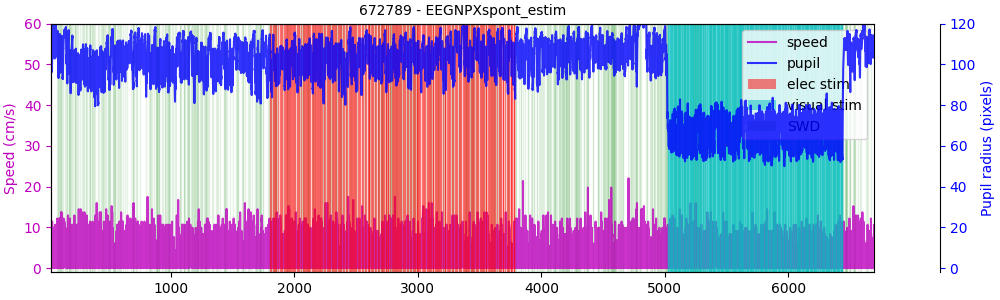

In [18]:
fig, ax = plt.subplots(figsize=(10,3), constrained_layout=True)
legenditems = []

## Running ##
run, = ax.plot(speedts, speed, color='m', alpha=0.8, label='speed')
legenditems.append(run)
ax.set_ylabel('Speed (cm/s)', color='m')
ax.tick_params(axis='y', colors='m')
ax.set_xlim([speedts[0], speedts[-1]])
ax.set_ylim([-1, 60])

## Iso signal ##
# isoax = ax.twinx()
# isp, = isoax.plot(isots, iso_level, color='g', alpha=0.8, label='iso')
# legenditems.append(isp)
# isoax.set_ylabel('Isoflurane (%)', color='g')
# isoax.tick_params(axis='y', colors='g')
# isoax.set_ylim([-0.1, 5.2])

## Pupil ##
if sm_pupil is not None:
    pupax = ax.twinx()
    pupax.spines.right.set_position(("axes", 1.08))
    pup, = pupax.plot(pupilts, sm_pupil, color='b', alpha=0.8, label='pupil')
    legenditems.append(pup)
    pupax.set_xlim([pupilts[0], pupilts[-1]])
    pupax.set_ylim([-2, 120])
    pupax.set_xlabel('Time (s)')
    pupax.set_ylabel('Pupil radius (pixels)', color='b')
    pupax.tick_params(axis='y', colors='b')

## Add stim events ##
if stim_log is not None:
    for stype in np.unique(stim_log.stim_type.values):
        if stype == 'circle':
            evcol = 'c'
            evlabel = 'visual stim'
        elif stype == 'biphasic':
            evcol = 'r'
            evlabel = 'elec stim'
        stypeevents = stim_log[stim_log['stim_type'] == stype].onset.values
        for eventi_on in stypeevents:
            ax.axvline(eventi_on, color=evcol, linewidth=1.0, alpha=0.5)
        legenditems.append(mpatches.Rectangle((0, 0), 1, 1, fc=evcol, alpha=0.5, label=evlabel))

## Add SWD events ##
if autoSWD_df is not None:
    for ii, SWDi in autoSWD_df.iterrows():
        ax.axvspan(SWDi.onset, SWDi.offset, color='g', alpha=0.1)
    legenditems.append(mpatches.Rectangle((0, 0), 1, 1, fc='g', alpha=0.2, label='SWD'))

## Add first injection time, if possible ##
if exprow.inj_time > 0:
    injt = ax.axvline(exprow.inj_time, color='chartreuse', linestyle='dashed', linewidth=2.0, alpha=0.8, label='injection')
    legenditems.append(injt)

## Set title and legend ##
ax.set_title('{} - {}'.format(exp.mouse, exp_tag))
ax.legend(handles = legenditems, loc='upper right')

## Load unit data

In [19]:
evoked_folder = os.path.join(exp.data_folder, 'evoked_data')
fn_units_info = os.path.join(evoked_folder, 'all_units_info.csv')
if os.path.exists(fn_units_info):
    unit_info = pd.read_csv(fn_units_info)
    with open(os.path.join(evoked_folder, 'units_allspikes.pkl'), 'rb') as unit_file:
        all_unit_all_spikes = pickle.load(unit_file)
else:
    print('{} not found. Not analyzing this subject.'.format(fn_units_stats))

unit_info.head()

,unit_id,probe,peak_ch,depth,spike_duration,region,CCF_AP,CCF_DV,CCF_ML,firing_rate,presence_ratio,isi_viol,amplitude_cutoff,spike_count,parent_region
0,B0,probeB,0,3640,0.576884,AMv,253,179,195,9.418763,0.99,0.016637,0.000034,62190,TH
1,B1,probeB,0,3640,0.590620,AMv,253,179,195,8.409945,0.99,0.089089,0.307189,55529,TH
2,B2,probeB,0,3640,0.535678,AMv,253,179,195,4.729525,0.99,0.139577,0.356767,31228,TH
3,B3,probeB,0,3640,0.576884,AMv,253,179,195,2.060496,0.99,0.361000,0.500000,13605,TH
4,B4,probeB,1,3640,0.508208,AMv,253,179,195,6.020648,0.99,0.075170,0.041239,39753,TH


Plot some of the quality metrics for all cells. The following are used by the AllenSDK:
<br> -  ISI violations (default < 0.5 
<br> -   amplitude cutoff (default < 0. 
<br> -    presence ratio (default > 0.9) * don't typically use this oneow,

## Loop through all units to get spontaneous firing rates

In [20]:
deltat = 1. # window size, s

In [21]:
atime = eegts[0]
if exprow.genotype == 'GAT1-KO':
    print('GAT1: choose time before any stimuli')
    btime = stim_log.onset.values[0]
    print(' Spontaneous time: {:.2f} s'.format(btime-atime))
else:
    print('Control: some experiments are saline/psilocybin/isoflurane')
    if exprow.drug == 'isoflurane':
        print(' First stim: {:.2f} s; Iso on: {:.2f} s'.format(stim_log.onset.values[0], isots[iso_level > 4][0]))
        btime = np.min([stim_log.onset.values[0], isots[iso_level > 4][0]])
        print(' Spontaneous time: {:.2f} s'.format(btime-atime))
    else:
        print(' First stim: {:.2f} s; First injection: {:.2f}'.format(stim_log.onset.values[0], exprow.inj_time))
        btime = np.min([stim_log.onset.values[0], exprow.inj_time])
        print(' Spontaneous time: {:.2f} s'.format(btime-atime))
spontbins = np.arange(atime, btime, deltat)
spontSWD = autoSWD_df[(autoSWD_df['onset'] > atime) & (autoSWD_df['offset'] < btime)]

GAT1: choose time before any stimuli
 Spontaneous time: 1723.91 s


In [22]:
compstart = time.time()
spontFR = []
spontBR = []
spont_burstratio = []
units_SWD_FR = []
units_nonSWD_FR = []
units_SWD_BR = []
units_nonSWD_BR = []
units_SWD_burstratio = []
units_nonSWD_burstratio = []
for unitind, unitrow in unit_info.iterrows():
    uspikes = all_unit_all_spikes[unitrow.unit_id]['spikes']
    ubursts = all_unit_all_spikes[unitrow.unit_id]['bursts']
    ubcs = all_unit_all_spikes[unitrow.unit_id]['burst_counts']
    ## Spontaneous ##
    spikecounts, edges = np.histogram(uspikes, spontbins)
    spontFR.append(np.mean(spikecounts / deltat))
    burstcounts, edges = np.histogram(ubursts, spontbins)
    spontBR.append(np.mean(burstcounts / deltat))
    ## Burst ratio ##
    spont_burstratio.append(
        np.sum(ubcs[np.nonzero((ubursts >= atime) & (ubursts <= btime))[0]]) / len(np.nonzero((uspikes >= atime) & (uspikes <= btime))[0]))


    ## Get SWD info ##
    event_SWD_FR = []
    event_SWD_BR = []
    totSWDspikec = []
    totSWDburstc = []
    event_nonSWD_FR = []
    event_nonSWD_BR = []
    totnonSWDspikec = []
    totnonSWDburstc = []
    for j in range(len(spontSWD)-1):
        SWDeventj = spontSWD.iloc[j]
        SWDeventjj = spontSWD.iloc[j+1]
    
        ## within SWD ##
        SWDspikec = len(np.nonzero((uspikes >= SWDeventj.onset) & (uspikes <= SWDeventj.offset))[0])
        event_SWD_FR.append(SWDspikec / (SWDeventj.offset - SWDeventj.onset))
        totSWDspikec.append(SWDspikec)
    
        burstinds = np.nonzero((ubursts >= SWDeventj.onset) & (ubursts <= SWDeventj.offset))[0]
        event_SWD_BR.append(len(burstinds) / (SWDeventj.offset - SWDeventj.onset))
        totSWDburstc.append(np.sum(ubcs[burstinds]))
    
        ## out of SWD ##
        nonSWDspikec = len(np.nonzero((uspikes >= SWDeventj.offset) & (uspikes <= SWDeventjj.onset))[0])
        event_nonSWD_FR.append(nonSWDspikec / (SWDeventjj.onset - SWDeventj.offset))
        totnonSWDspikec.append(nonSWDspikec)
    
        nonburstinds = np.nonzero((ubursts >= SWDeventj.offset) & (ubursts <= SWDeventjj.onset))[0]
        event_nonSWD_BR.append(len(nonburstinds) / (SWDeventjj.onset - SWDeventj.offset))
        totnonSWDburstc.append(np.sum(ubcs[nonburstinds]))
    units_SWD_FR.append(np.mean(event_SWD_FR))
    units_nonSWD_FR.append(np.mean(event_nonSWD_FR))
    units_SWD_BR.append(np.mean(event_SWD_BR))
    units_nonSWD_BR.append(np.mean(event_nonSWD_BR))
    units_SWD_burstratio.append(np.sum(totSWDburstc) / np.sum(totSWDspikec))
    units_nonSWD_burstratio.append(np.sum(totnonSWDburstc) / np.sum(totnonSWDspikec))

unit_info['spont_FR'] = spontFR
unit_info['spont_BR'] = spontBR
unit_info['burst_ratio'] = spont_burstratio
unit_info['SWD_FR'] = units_SWD_FR
unit_info['nonSWD_FR'] = units_nonSWD_FR
unit_info['SWD_BR'] = units_SWD_BR
unit_info['nonSWD_BR'] = units_nonSWD_BR
unit_info['SWD_burst_ratio'] = units_SWD_burstratio
unit_info['nonSWD_burst_ratio'] = units_nonSWD_burstratio
compend = time.time()
print('Computation time: {:.2f} min'.format((compend-compstart)/60))

C:\Users\lesliec\Miniconda3\envs\tbd_eeg\lib\site-packages\ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in long_scalars
C:\Users\lesliec\Miniconda3\envs\tbd_eeg\lib\site-packages\ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\lesliec\Miniconda3\envs\tbd_eeg\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in long_scalars
C:\Users\lesliec\Miniconda3\envs\tbd_eeg\lib\site-packages\ipykernel_launcher.py:60: RuntimeWarning: invalid value encountered in long_scalars
C:\Users\lesliec\Miniconda3\envs\tbd_eeg\lib\site-packages\ipykernel_launcher.py:60: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\lesliec\Miniconda3\envs\tbd_eeg\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in double_scalars


Computation time: 3.64 min


In [23]:
unit_info.head()

,unit_id,probe,peak_ch,depth,spike_duration,region,CCF_AP,CCF_DV,CCF_ML,firing_rate,presence_ratio,isi_viol,amplitude_cutoff,spike_count,parent_region,spont_FR,spont_BR,burst_ratio,SWD_FR,nonSWD_FR,SWD_BR,nonSWD_BR,SWD_burst_ratio,nonSWD_burst_ratio
0,B0,probeB,0,3640,0.576884,AMv,253,179,195,9.418763,0.99,0.016637,0.000034,62190,TH,9.100987,0.315148,0.063273,5.194705,8.827456,0.297656,0.292783,0.116959,0.060632
1,B1,probeB,0,3640,0.590620,AMv,253,179,195,8.409945,0.99,0.089089,0.307189,55529,TH,7.189205,0.066164,0.016055,3.045485,6.823664,0.095416,0.066364,0.048662,0.014783
2,B2,probeB,0,3640,0.535678,AMv,253,179,195,4.729525,0.99,0.139577,0.356767,31228,TH,4.597795,0.030760,0.011478,1.649302,4.373807,0.031793,0.027418,0.022727,0.011172
3,B3,probeB,0,3640,0.576884,AMv,253,179,195,2.060496,0.99,0.361000,0.500000,13605,TH,2.113175,0.033662,0.027991,1.149698,1.945563,0.035524,0.036650,0.054422,0.026911
4,B4,probeB,1,3640,0.508208,AMv,253,179,195,6.020648,0.99,0.075170,0.041239,39753,TH,4.760302,0.184562,0.080795,3.632534,4.482238,0.140764,0.142553,0.080913,0.080850


Plot all units from regions

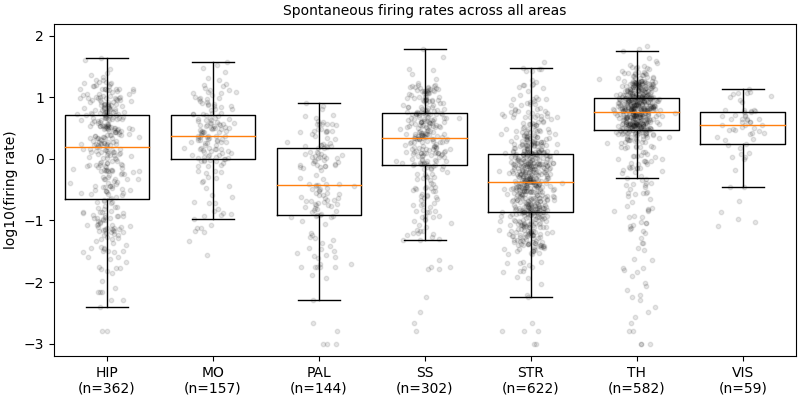

In [24]:
fig, ax = plt.subplots(figsize=(8,4), constrained_layout=True)
parent_regions = np.unique(unit_info['parent_region'].values)

rlabels = []
for ii, pregi in enumerate(parent_regions):
    regidf = unit_info[unit_info['parent_region'] == pregi]
    rlabels.append('{}\n(n={:d})'.format(pregi, len(regidf)))
    yvals = np.log10(regidf['spont_FR'].values + 1E-3)
    xs = np.random.normal(ii, 0.1, len(yvals))
    ax.boxplot(yvals, positions=[ii], widths=[0.8], showfliers=False,)
    ax.scatter(xs, yvals, c='k', marker='o', s=10, alpha=0.1)
ax.set_xticks(np.arange(len(parent_regions)))
ax.set_xticklabels(rlabels)
ax.set_ylim([-3.2, 2.2])
ax.set_ylabel('log10(firing rate)')
ax.set_title('Spontaneous firing rates across all areas')

## Save ##
fig_name = '{}{}_spontFR_allregions.png'.format(exp.mouse, exp_tag)
# fig.savefig(os.path.join(plotsavedir, fig_name), transparent=False)

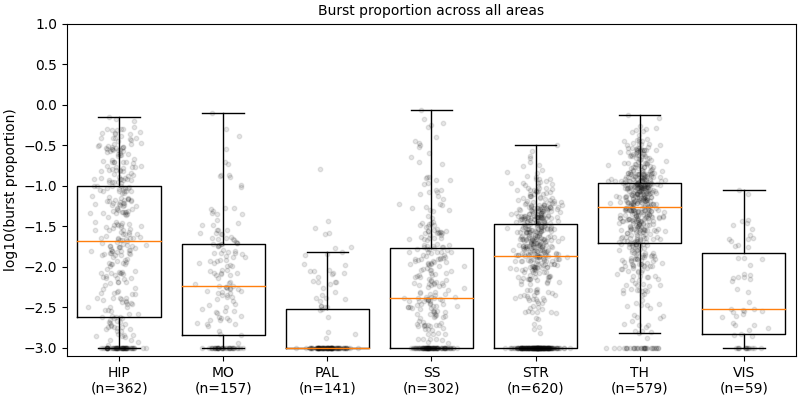

In [29]:
fig, ax = plt.subplots(figsize=(8,4), constrained_layout=True)
parent_regions = np.unique(unit_info['parent_region'].values)

rlabels = []
for ii, pregi in enumerate(parent_regions):
    regidf = unit_info[unit_info['parent_region'] == pregi]
    yvals = np.log10(regidf['burst_ratio'].values[~np.isnan(regidf['burst_ratio'].values)] + 1E-3)
    rlabels.append('{}\n(n={:d})'.format(pregi, len(yvals)))
    # yvals = regidf['burst_ratio'].values
    xs = np.random.normal(ii, 0.1, len(yvals))
    ax.boxplot(yvals, positions=[ii], widths=[0.8], showfliers=False,)
    ax.scatter(xs, yvals, c='k', marker='o', s=10, alpha=0.1)
ax.set_xticks(np.arange(len(parent_regions)))
ax.set_xticklabels(rlabels)
ax.set_ylim([-3.1, 1.0])
ax.set_ylabel('log10(burst proportion)')
ax.set_title('Burst proportion across all areas')

## Save ##
fig_name = '{}{}_spontBurstproportion_allregions.png'.format(exp.mouse, exp_tag)
# fig.savefig(os.path.join(plotsavedir, fig_name), transparent=False)

**Looking at the SWD/nonSWD spiking stats**

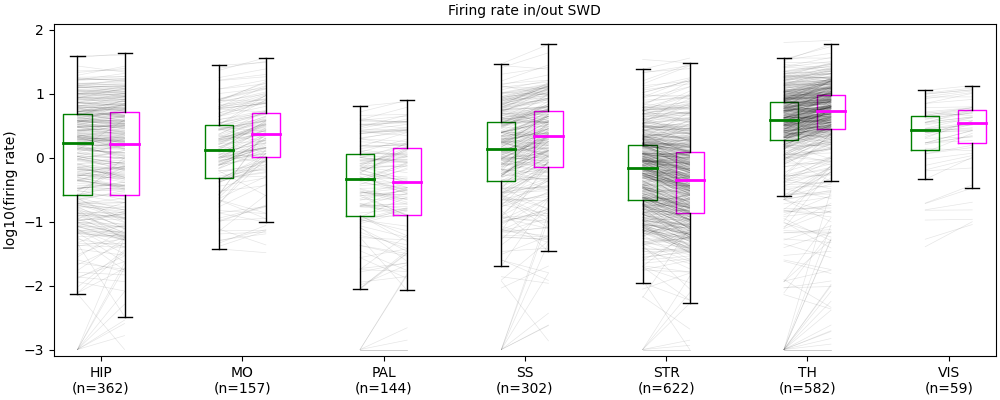

In [25]:
metric = '_FR' # '_FR', '_BR', '_burst_ratio'
fig, ax = plt.subplots(figsize=(10,4), constrained_layout=True)
parent_regions = np.unique(unit_info['parent_region'].values)
xlocs = np.arange(len(parent_regions) * (3)).reshape((len(parent_regions), -1))
rlabels = []
for ii, pregi in enumerate(parent_regions):
    regidf = unit_info[unit_info['parent_region'] == pregi]
    rlabels.append('{}\n(n={:d})'.format(pregi, len(regidf)))
    yval_list = []
    xlist = []
    for jj, (evname, evcol) in enumerate(zip(['SWD', 'nonSWD'], ['green', 'magenta'])):
        yvals = np.log10(regidf[evname + metric].values + 1E-3)
        # yvals = np.log10(BRs[~np.isnan(BRs)] + 1E-3)
        yval_list.append(yvals)
        xlist.append(xlocs[ii, jj])
        ax.boxplot(
            yvals, positions=[xlocs[ii, jj]], widths=[0.6], showfliers=False,
            medianprops={'color': evcol, 'linewidth': 2}, boxprops={'color': evcol}
        )
    ax.plot(np.array(xlist), np.array(yval_list), color='k', linewidth=0.5, alpha=0.1)
ax.set_xticks(np.mean(xlocs[:,:-1], axis=1))
ax.set_xticklabels(rlabels)
ax.set_ylim([-3.1, 2.1])
ax.set_ylabel('log10(firing rate)')
ax.set_title('Firing rate in/out SWD')

## Save ##
fig_name = '{}{}_SWD_FR_allregions.png'.format(exp.mouse, exp_tag)
# fig.savefig(os.path.join(plotsavedir, fig_name), transparent=False)

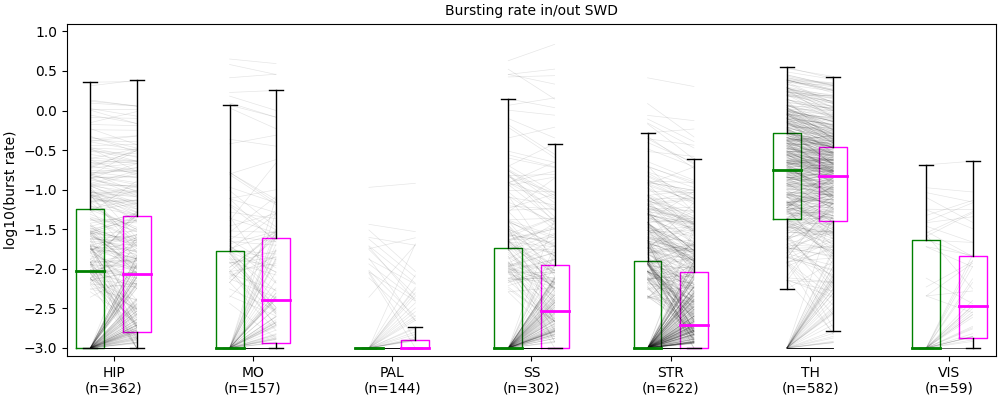

In [26]:
metric = '_BR' # '_FR', '_BR', '_burst_ratio'
fig, ax = plt.subplots(figsize=(10,4), constrained_layout=True)
parent_regions = np.unique(unit_info['parent_region'].values)
xlocs = np.arange(len(parent_regions) * (3)).reshape((len(parent_regions), -1))
rlabels = []
for ii, pregi in enumerate(parent_regions):
    regidf = unit_info[unit_info['parent_region'] == pregi]
    rlabels.append('{}\n(n={:d})'.format(pregi, len(regidf)))
    yval_list = []
    xlist = []
    for jj, (evname, evcol) in enumerate(zip(['SWD', 'nonSWD'], ['green', 'magenta'])):
        yvals = np.log10(regidf[evname + metric].values + 1E-3)
        # yvals = np.log10(BRs[~np.isnan(BRs)] + 1E-3)
        yval_list.append(yvals)
        xlist.append(xlocs[ii, jj])
        ax.boxplot(
            yvals, positions=[xlocs[ii, jj]], widths=[0.6], showfliers=False,
            medianprops={'color': evcol, 'linewidth': 2}, boxprops={'color': evcol}
        )
    ax.plot(np.array(xlist), np.array(yval_list), color='k', linewidth=0.5, alpha=0.1)
ax.set_xticks(np.mean(xlocs[:,:-1], axis=1))
ax.set_xticklabels(rlabels)
ax.set_ylim([-3.1, 1.1])
ax.set_ylabel('log10(burst rate)')
ax.set_title('Bursting rate in/out SWD')

## Save ##
fig_name = '{}{}_SWD_BR_allregions.png'.format(exp.mouse, exp_tag)
# fig.savefig(os.path.join(plotsavedir, fig_name), transparent=False)

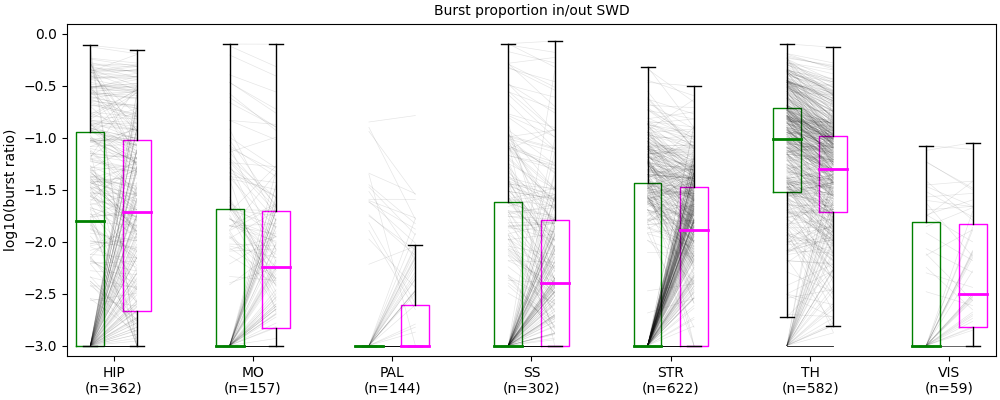

In [32]:
## Log Y-axis ##
metric = '_burst_ratio' # '_FR', '_BR', '_burst_ratio'
fig, ax = plt.subplots(figsize=(10,4), constrained_layout=True)
parent_regions = np.unique(unit_info['parent_region'].values)
xlocs = np.arange(len(parent_regions) * (3)).reshape((len(parent_regions), -1))
rlabels = []
for ii, pregi in enumerate(parent_regions):
    regidf = unit_info[unit_info['parent_region'] == pregi]
    rlabels.append('{}\n(n={:d})'.format(pregi, len(regidf)))
    yval_list = []
    xlist = []
    for jj, (evname, evcol) in enumerate(zip(['SWD', 'nonSWD'], ['green', 'magenta'])):
        tempyvals = regidf[evname + metric].values
        yvals = np.log10(tempyvals[~np.isnan(tempyvals)] + 1E-3)
        yval_list.append(np.log10(tempyvals + 1E-3))
        xlist.append(xlocs[ii, jj])
        ax.boxplot(
            yvals, positions=[xlocs[ii, jj]], widths=[0.6], showfliers=False,
            medianprops={'color': evcol, 'linewidth': 2}, boxprops={'color': evcol}
        )
    ax.plot(np.array(xlist), np.array(yval_list), color='k', linewidth=0.5, alpha=0.1)
ax.set_xticks(np.mean(xlocs[:,:-1], axis=1))
ax.set_xticklabels(rlabels)
ax.set_ylim([-3.1, 0.1])
ax.set_ylabel('log10(burst ratio)')
ax.set_title('Burst proportion in/out SWD')

## Save ##
fig_name = '{}{}_SWD_burstprop_allregions.png'.format(exp.mouse, exp_tag)
fig.savefig(os.path.join(plotsavedir, fig_name), transparent=False)

## Unit classification

In [32]:
regi_unitdf = unit_info[unit_info['parent_region'] == 'STR']
print(len(regi_unitdf))
print(np.unique(regi_unitdf['region'].values))
print(np.unique(regi_unitdf['probe'].values))
regi_unitdf.head()

622
['CP' 'STR' 'VL' 'ccb']
['probeD' 'probeF']


,unit_id,probe,peak_ch,depth,spike_duration,region,CCF_AP,CCF_DV,CCF_ML,firing_rate,presence_ratio,isi_viol,amplitude_cutoff,spike_count,parent_region,spont_FR,spont_BR,burst_ratio,SWD_FR,nonSWD_FR,SWD_BR,nonSWD_BR,SWD_burst_ratio,nonSWD_burst_ratio
1109,D185,probeD,170,2000,0.206030,VL,266,117,126,1.185871,0.99,0.000000,0.004952,7830,STR,1.186303,0.000000,0.000000,1.153924,1.169045,0.0,0.000000,0.0,0.000000
1110,D189,probeD,198,1720,0.494472,CP,270,106,120,6.830193,0.99,0.045022,0.121545,45098,STR,2.310505,0.002322,0.003011,2.227063,2.415583,0.0,0.011702,0.0,0.003261
1111,D193,probeD,205,1660,0.233501,VL,270,104,119,3.264250,0.99,0.356942,0.443380,21553,STR,1.178178,0.001161,0.002956,1.080161,1.206500,0.0,0.000702,0.0,0.003188
1112,D195,probeD,209,1620,0.206030,VL,270,102,118,1.420016,0.95,0.816397,0.078357,9376,STR,0.090540,0.000580,0.025641,0.061414,0.106408,0.0,0.000160,0.0,0.027027
1113,D197,probeD,208,1620,0.343384,VL,270,103,118,5.126356,0.99,0.120965,0.068554,33848,STR,0.249565,0.000000,0.000000,0.164825,0.226399,0.0,0.000000,0.0,0.000000


In [31]:
tempdf = regi_unitdf[regi_unitdf['region'] == 'ccb']
print(len(tempdf))

5


## Investigate some single units

In [25]:
regi_unitdf = unit_info[unit_info['parent_region'] == 'STR']
print(len(regi_unitdf))
print(np.unique(regi_unitdf['region'].values))
regi_unitdf.head()

586
['CP' 'ccb']


,unit_id,probe,peak_ch,depth,spike_duration,region,CCF_AP,CCF_DV,CCF_ML,firing_rate,presence_ratio,isi_viol,amplitude_cutoff,spike_count,parent_region,spont_FR,spont_BR,burst_ratio,SWD_FR
1643,F32,probeF,42,3260,0.659296,CP,205,182,186,0.008169,0.41,0.000000,0.500000,58,STR,0.006893,0.000000,0.000000,0.008739
1644,F33,probeF,43,3260,0.343384,CP,205,182,186,10.099695,0.99,0.007245,0.000308,71709,STR,10.185578,0.001591,0.000677,5.560259
1645,F34,probeF,43,3260,0.618090,CP,205,182,186,0.759143,0.99,0.366406,0.033224,5390,STR,0.347826,0.000000,0.000000,0.266990
1646,F36,probeF,50,3180,0.782915,CP,204,179,184,0.004789,0.25,0.000000,0.500000,34,STR,0.002651,0.000000,0.000000,0.001390
1647,F37,probeF,53,3160,0.247236,CP,204,178,184,8.264091,0.99,0.006184,0.046901,58676,STR,10.238600,0.006893,0.002019,6.677388


In [26]:
regi_unitdf[80:90]

,unit_id,probe,peak_ch,depth,spike_duration,region,CCF_AP,CCF_DV,CCF_ML,firing_rate,presence_ratio,isi_viol,amplitude_cutoff,spike_count,parent_region,spont_FR,spont_BR,burst_ratio,SWD_FR
1723,F128,probeF,96,2720,0.645561,CP,200,161,177,1.115052,0.99,10.826759,0.025554,7917,STR,1.172322,0.010604,0.028042,1.914032
1724,F129,probeF,96,2720,0.645561,CP,200,161,177,0.271827,0.99,24.290916,0.074886,1930,STR,0.278367,0.001060,0.011429,0.595310
1725,F130,probeF,96,2720,0.618090,CP,200,161,177,0.630412,0.99,10.626480,0.120878,4476,STR,0.583775,0.007423,0.040872,0.933454
1726,F131,probeF,97,2720,0.645561,CP,200,160,176,1.311246,0.99,6.601136,0.022852,9310,STR,1.969247,0.015376,0.025848,2.662587
1727,F132,probeF,97,2720,0.673032,CP,200,160,176,0.268165,0.99,9.543091,0.025758,1904,STR,0.263521,0.000530,0.006036,0.582097
1728,F133,probeF,97,2720,0.631826,CP,200,160,176,0.723932,0.99,8.159027,0.004859,5140,STR,0.922057,0.007423,0.025877,1.693579
1729,F134,probeF,97,2720,0.810385,CP,200,160,176,0.210982,0.99,27.276196,0.032920,1498,STR,0.264581,0.002121,0.024048,0.562441
1730,F136,probeF,98,2700,0.631826,CP,200,160,176,0.178589,0.96,26.482628,0.033632,1268,STR,0.167020,0.001060,0.022222,0.284228
1731,F137,probeF,98,2700,0.755444,CP,200,160,176,0.148730,0.99,11.932234,0.047205,1056,STR,0.110817,0.000530,0.014354,0.277487
1732,F138,probeF,98,2700,0.604355,CP,200,160,176,1.308289,0.99,8.975004,0.341608,9289,STR,0.986744,0.015907,0.051585,1.724124


In [27]:
unitind = 792
unitrow = unit_info.iloc[unitind]
print('Unit {}, {}: spike duration={:.2f}, spike count={:d}'.format(unitrow.unit_id, unitrow.region, unitrow.spike_duration, unitrow.spike_count))

Unit C511, dhc: spike duration=0.49, spike count=37971


In [28]:
uspikes = all_unit_all_spikes[unitrow.unit_id]['spikes']
print(len(uspikes))
ubursts = all_unit_all_spikes[unitrow.unit_id]['bursts']
print(len(ubursts))
ubcs = all_unit_all_spikes[unitrow.unit_id]['burst_counts']

37971
121


### Get the spontaneous time window to get mean firing rate

In [29]:
deltat = 1.0 # size of time bins (s)

In [30]:
atime = eegts[0]
if exprow.genotype == 'GAT1-KO':
    print('GAT1: choose time before any stimuli')
    btime = stim_log.onset.values[0]
    print(' Spontaneous time: {:.2f} s'.format(btime-atime))
else:
    print('Control: some experiments are saline/psilocybin/isoflurane')
    if exprow.drug == 'isoflurane':
        btime = np.min([stim_log.onset.values[0], isots[iso_level > 4][0]])
        print(' Spontaneous time: {:.2f} s'.format(btime-atime))
    else:
        btime = np.min([stim_log.onset.values[0], exprow.inj_time])
        print(' Spontaneous time: {:.2f} s'.format(btime-atime))
spontbins = np.arange(atime, btime, deltat)

GAT1: choose time before any stimuli
 Spontaneous time: 1886.30 s


In [31]:
## Firing rate ##
spikecounts, edges = np.histogram(uspikes, spontbins)
unitFR = np.mean(spikecounts / deltat)
print('Unit {} mean firing rate: {:.2f} Hz [log10={:.2f}]'.format(unitrow.unit_id, unitFR, np.log10(unitFR)))

## Burst rate ##
burstcounts, edges = np.histogram(ubursts, spontbins)
unitBR = np.mean(burstcounts / deltat)
print('Unit {} mean burst rate: {:.2f} Hz [log10={:.2f}]'.format(unitrow.unit_id, unitBR, np.log10(unitBR)))

## Compute the burst proportion: # spikes in bursts / # total spikes ##
burst_ratio = np.sum(ubcs[np.nonzero((ubursts >= atime) & (ubursts <= btime))[0]]) / len(np.nonzero((uspikes >= atime) & (uspikes <= btime))[0])
print('Unit {} burst proportion: {:.2f}'.format(unitrow.unit_id, burst_ratio))

Unit C511 mean firing rate: 4.95 Hz [log10=0.69]
Unit C511 mean burst rate: 0.01 Hz [log10=-2.10]
Unit C511 burst proportion: 0.00


### Get spontaneous firing for SWD and not

In [32]:
autoSWD_df.tail()

,onset,offset,duration,spike_count,SWD_spike_times
1047,7092.399350,7093.288549,0.889199,4,"[7092.399349751857, 7092.722949542853, 7093.09..."
1048,7125.280934,7125.966134,0.685200,4,"[7125.280934257315, 7125.436934206937, 7125.79..."
1049,7131.890532,7132.539332,0.648800,3,"[7131.890532122845, 7132.208932020022, 7132.53..."
1050,7144.637728,7145.770128,1.132400,5,"[7144.63772800633, 7144.952127904799, 7145.269..."
1051,7149.089327,7149.818126,0.728800,4,"[7149.089326568754, 7149.474526444359, 7149.64..."


In [33]:
spontSWD = autoSWD_df[(autoSWD_df['onset'] > atime) & (autoSWD_df['offset'] < btime)]
spontSWD.tail()

,onset,offset,duration,spike_count,SWD_spike_times
385,1906.785480,1907.295476,0.509997,3,"[1906.7854796428342, 1907.1174774985468, 1907...."
386,1911.672248,1913.563836,1.891588,11,"[1911.6722480804754, 1911.8194471297552, 1911...."
387,1915.677422,1916.507817,0.830395,6,"[1915.6774222121037, 1915.8370211812958, 1916...."
388,1917.570610,1918.447804,0.877194,6,"[1917.5706099844992, 1917.741408881354, 1917.9..."
389,1932.274915,1932.839711,0.564796,4,"[1932.2749150132404, 1932.457313835174, 1932.6..."


In [34]:
compstart = time.time()
all_SWD_FR = []
all_SWD_BR = []
totSWDspikec = []
totSWDburstc = []
all_nonSWD_FR = []
all_nonSWD_BR = []
totnonSWDspikec = []
totnonSWDburstc = []
for j in range(len(spontSWD)-1):
    SWDeventj = spontSWD.iloc[j]
    SWDeventjj = spontSWD.iloc[j+1]

    ## within SWD ##
    SWDspikec = len(np.nonzero((uspikes >= SWDeventj.onset) & (uspikes <= SWDeventj.offset))[0])
    all_SWD_FR.append(SWDspikec / (SWDeventj.offset - SWDeventj.onset))
    totSWDspikec.append(SWDspikec)

    burstinds = np.nonzero((ubursts >= SWDeventj.onset) & (ubursts <= SWDeventj.offset))[0]
    all_SWD_BR.append(len(burstinds) / (SWDeventj.offset - SWDeventj.onset))
    totSWDburstc.append(np.sum(ubcs[burstinds]))

    ## out of SWD ##
    nonSWDspikec = len(np.nonzero((uspikes >= SWDeventj.offset) & (uspikes <= SWDeventjj.onset))[0])
    all_nonSWD_FR.append(nonSWDspikec / (SWDeventjj.onset - SWDeventj.offset))
    totnonSWDspikec.append(nonSWDspikec)

    nonburstinds = np.nonzero((ubursts >= SWDeventj.offset) & (ubursts <= SWDeventjj.onset))[0]
    all_nonSWD_BR.append(len(nonburstinds) / (SWDeventjj.onset - SWDeventj.offset))
    totnonSWDburstc.append(np.sum(ubcs[nonburstinds]))
compend = time.time()
print(compend - compstart)

0.2887582778930664


In [46]:
print(np.mean(all_SWD_FR))
print(np.mean(all_nonSWD_FR))

4.3350227633322875
5.189754382288044


In [47]:
print(np.mean(all_SWD_BR))
print(np.mean(all_nonSWD_BR))

0.0017206665486152013
0.007092745842638542


In [57]:
print(np.sum(totSWDburstc) / np.sum(totSWDspikec))
print(np.sum(totnonSWDburstc) / np.sum(totnonSWDspikec))

0.0017201834862385322
0.005693855932203389


In [55]:
np.sum(totSWDburstc)

3

Individual trial

In [34]:
indi = 0
SWDeventi = spontSWD.iloc[indi]
SWDeventii = spontSWD.iloc[indi+1]

In [35]:
SWDeventi

onset                                                      55.904357
offset                                                     56.411553
duration                                                    0.507196
spike_count                                                        4
SWD_spike_times    [55.904356981838816, 56.06715561497322, 56.237...
Name: 0, dtype: object

In [36]:
SWDeventii

onset                                                      61.299912
offset                                                     63.137896
duration                                                    1.837985
spike_count                                                        9
SWD_spike_times    [61.299911680487725, 61.5323097292619, 61.8255...
Name: 1, dtype: object

In [41]:
SWDspikec = len(np.nonzero((uspikes >= SWDeventi.onset) & (uspikes <= SWDeventi.offset))[0])
SWD_FR = SWDspikec / (SWDeventi.offset - SWDeventi.onset)
print(SWD_FR)

nonSWDspikec = len(np.nonzero((uspikes >= SWDeventi.offset) & (uspikes <= SWDeventii.onset))[0])
nonSWD_FR = nonSWDspikec / (SWDeventii.onset - SWDeventi.offset)
print(nonSWD_FR)

0.0
5.523325974423183


In [42]:
SWDburstc = len(np.nonzero((ubursts >= SWDeventi.onset) & (ubursts <= SWDeventi.offset))[0])
SWD_BR = SWDburstc / (SWDeventi.offset - SWDeventi.onset)
print(SWD_BR)

nonSWDburstc = len(np.nonzero((ubursts >= SWDeventi.offset) & (ubursts <= SWDeventii.onset))[0])
nonSWD_BR = nonSWDburstc / (SWDeventii.onset - SWDeventi.offset)
print(nonSWD_BR)

0.0
0.0
